In [9]:
import pandas as pd
import math as math
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [10]:
# Loading in Data Sets
crop_yield_df = pd.read_csv('crop_yields.csv')
pesticides_df = pd.read_csv('epest_county_estimates.csv')

Data Preprocessing!

In [11]:
# Limiting Crop Yield Data to the United States only
us_yields_df = crop_yield_df[crop_yield_df['country'] == 'United States']

In [12]:
# Limiting the columns we are using to the 8 yields we are exploring, in addition to the year column
us_yields_df = us_yields_df[['year','maize_yield', 'cotton_yield', 'soybean_yield', 'fruit_yield', 'potato_yield', 'tobacco_yield', 
                             'vegetables_yield', 'wheat_yield']]

In [13]:
# Turning the year column into an integer and limiting it to 1992 - 2019 (when we have data for pesticides)
us_yields_df["year"] = us_yields_df["year"].astype(str).astype(int)
us_yields_df = us_yields_df[us_yields_df['year'] >= 1992]
us_yields_df = us_yields_df[us_yields_df['year'] <= 2019]

In [14]:
# Checking to make sure that us_yields_df is just the United States data from 1992 - 2023 and only the 8 yields we are interesting in
num_rows = us_yields_df.shape[0]
num_cols = us_yields_df.shape[1]
print(num_rows) # Returns 28; just the US values for the 28 years of interest (down from 14577 at the start)
print(num_cols) # Returns 9; the 8 yields and the year (down from 205 at the start)

28
9


Pesticides Set:

In [15]:
# Turning the year column into an integer and checking when the earliest and latest data is from
pesticides_df["YEAR"] = pesticides_df["YEAR"].astype(str).astype(int)
print(pesticides_df["YEAR"].min()) # Returns 1992
print(pesticides_df["YEAR"].max()) # Returns 2019

1992
2019


In [16]:
# Drop rows with any na values in them (still have about 6.1 million rows)
pesticides_df.dropna(inplace=True)

In [17]:
# Make the KG Estimates for the pesticides floats
pesticides_df['EPEST_LOW_KG'] = pesticides_df['EPEST_LOW_KG'].astype(str).astype(float)
pesticides_df['EPEST_HIGH_KG'] = pesticides_df['EPEST_HIGH_KG'].astype(str).astype(float)

Determining best pesticides:

In [18]:
# Checking unique values in the "COMPOUND" column of the pesticides data ( = How many different pesticides are in the data set)
unique_values = pesticides_df['COMPOUND'].unique()
print(len(unique_values)) # Returns 533

533


In [19]:
# Putting all unique values in a list
unique_values_list = pesticides_df['COMPOUND'].unique().tolist()
print(unique_values_list)

['2,4-D', 'ACEPHATE', 'ACETAMIPRID', 'ACETOCHLOR', 'ATRAZINE', 'AZOXYSTROBIN', 'BENTAZONE', 'BENZOVINDIFLUPYR', 'BOSCALID', 'BROMACIL', 'BROMOXYNIL', 'CARBARYL', 'CHLORANTRANILIPROLE', 'CHLORIMURON', 'CHLORPYRIFOS', 'CLOTHIANIDIN', 'CYANTRANILIPROLE', 'CYPRODINIL', 'DIAZINON', 'DICAMBA', 'DICROTOPHOS', 'DIFLUBENZURON', 'DIMETHENAMID', 'DIMETHENAMID & DIMETHENAMID-P', 'DIMETHENAMID-P', 'DIMETHOATE', 'DIMETHOMORPH', 'DINOTEFURAN', 'DIURON', 'ETHOPROPHOS', 'ETOXAZOLE', 'FIPRONIL', 'FLUOMETURON', 'FLUOPICOLIDE', 'GLYPHOSATE', 'HALOSULFURON', 'HEXAZINONE', 'IMAZETHAPYR', 'IMIDACLOPRID', 'LINURON', 'MALATHION', 'METALAXYL', 'METCONAZOLE', 'METHOMYL', 'METHOXYFENOZIDE', 'METOLACHLOR', 'METOLACHLOR & METOLACHLOR-S', 'METOLACHLOR-S', 'METRIBUZIN', 'MYCLOBUTANIL', 'ORYZALIN', 'PERMETHRIN', 'PIPERONYL BUTOXIDE', 'PROPAZINE', 'PROPICONAZOLE', 'PYRACLOSTROBIN', 'PYRIMETHANIL', 'SIMAZINE', 'SULFENTRAZONE', 'SULFOXAFLOR', 'TEBUCONAZOLE', 'TEBUPIRIMPHOS', 'TEBUTHIURON', 'TERBUFOS', 'TETRACONAZOLE', 'T

In [20]:
# Create a dictionary where {key : value} is {pesticide : # of occurences} to determine the most pesticides for which we have the most data
pest_dict = {}

for each in unique_values_list:
    count_each = pesticides_df['COMPOUND'].value_counts().get(each, 0)
    pest_dict[each] = count_each

In [21]:
# Learning some things about the pesticide data
min_value = min(pest_dict.values())
max_value = max(pest_dict.values())
min_key = min(pest_dict, key=pest_dict.get)
max_key = max(pest_dict, key=pest_dict.get)
print(min_key,min_value)
print(max_key, max_value)

FLUVALINATE 3
GLYPHOSATE 84951


In [22]:
# Sort the dictionary values from highest to lowest to determine what pesticides we have the most data for
sorted_pest_dict = dict(sorted(pest_dict.items(), key=lambda item: item[1], reverse=True))

In [23]:
# Testing values to find cut off for around 10 pesticides
i = 0
for value in pest_dict.values():
    if value >= 65000:
        i += 1
print(i) # Returns 9

9


In [24]:
# Creating a list of all pesticides with over 55000 data points and checking to make sure == 9
best_pesticides_list = []
for key in pest_dict.keys():
    if pest_dict[key] >= 65000:
        best_pesticides_list.append(key)

print(best_pesticides_list) # List of 9 pesticides with the most data points over the last 30 years
print(len(best_pesticides_list)) # Returns 9 as expected

['2,4-D', 'ATRAZINE', 'CARBARYL', 'CHLORPYRIFOS', 'DICAMBA', 'GLYPHOSATE', 'CHLOROTHALONIL', 'PARAQUAT', 'PENDIMETHALIN']
9


In [25]:
# Dropping the pesticides from the data set which are not one of the 18 pesticides that we care about
for key in pest_dict.keys():
    if key not in best_pesticides_list:
        pesticides_df = pesticides_df.drop(pesticides_df[pesticides_df['COMPOUND'] == key].index)
    else:
        continue

In [26]:
# Checking what the number of rows should be
total = 0 
for key in pest_dict.keys():
    if key in best_pesticides_list:
        total += pest_dict[key]
    else:
        continue
print(total) # Returns 666258

666258


In [27]:
# Checking to make sure that pest_df is the correct set of data
num_rows = pesticides_df.shape[0]
num_cols = pesticides_df.shape[1]
print(num_rows) # Returns 666258; due to dropping NAs and reducing the dataset to the best_pesticides_list (down from 9562214 at the start)
print(num_cols) # Returns 6

666258
6


Creating Trend Lines and Regression Models

In [28]:
# Corn regression line
x = us_yields_df['year']
y = us_yields_df['maize_yield']
z = np.polyfit(x, y, 1)  
corn = np.poly1d(z)

In [29]:
# Bean regression line
x = us_yields_df['year']
y = us_yields_df['soybean_yield']
z = np.polyfit(x, y, 1)  
bean = np.poly1d(z)

In [30]:
# Cotton regression line
x = us_yields_df['year']
y = us_yields_df['cotton_yield']
z = np.polyfit(x, y, 1)  
cotton = np.poly1d(z)

In [31]:
# Fruit regression line
x = us_yields_df['year']
y = us_yields_df['fruit_yield']
z = np.polyfit(x, y, 1)  
fruit = np.poly1d(z)

In [32]:
# Potato regression line
x = us_yields_df['year']
y = us_yields_df['potato_yield']
z = np.polyfit(x, y, 1)  
potato = np.poly1d(z)

In [33]:
# Tobacco regression line
x = us_yields_df['year']
y = us_yields_df['tobacco_yield']
z = np.polyfit(x, y, 1)  
tobacco = np.poly1d(z)

In [34]:
# Vegetable regression line
x = us_yields_df['year']
y = us_yields_df['vegetables_yield']
z = np.polyfit(x, y, 1)  
vegetable = np.poly1d(z)

In [35]:
# Wheat regression line
x = us_yields_df['year']
y = us_yields_df['wheat_yield']
z = np.polyfit(x, y, 1)  
wheat = np.poly1d(z)

/var/folders/pv/ckwm7f6x45qbm656mtn075t00000gp/T/ipykernel_88338/3954030750.py:35: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['_Corn Data', 'Corn Yield', '_Potato Data', 'Potato Yield','_Vegetable Data', 'Vegetable Yield', '_Fruit Data', 'Fruit Yield'])


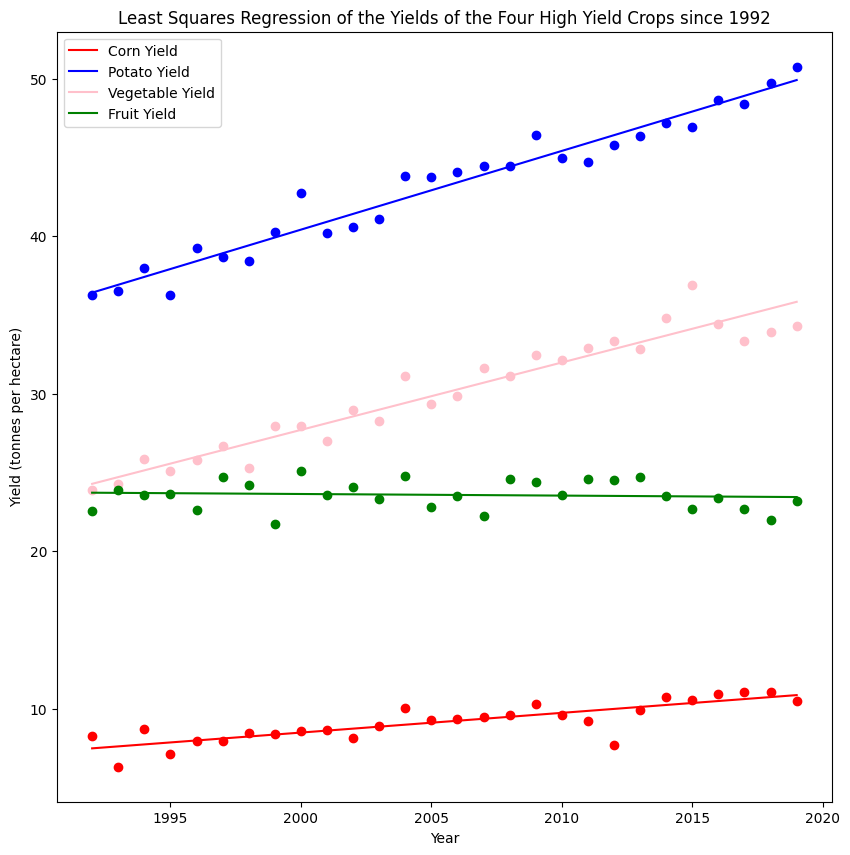

In [36]:
# Creating a plot with all of the trend lines and scatterplots

plt.rcParams["figure.figsize"] = (10,10)

# Corn line and points
x = us_yields_df['year']
y = us_yields_df['maize_yield']
plt.scatter(x, y, color='red')
plt.plot(x, corn(x), color='red')

# Potato line and points
x = us_yields_df['year']
y = us_yields_df['potato_yield']
plt.scatter(x, y, color='blue')
plt.plot(x, potato(x), color='blue')

# Vegetable line and points
x = us_yields_df['year']
y = us_yields_df['vegetables_yield']
plt.scatter(x, y, color='pink')
plt.plot(x, vegetable(x), color='pink')

# Fruit line and points
x = us_yields_df['year']
y = us_yields_df['fruit_yield']
plt.scatter(x, y, color='green')
plt.plot(x, fruit(x), color='green')

# Naming the axes and a title
plt.xlabel("Year")
plt.ylabel("Yield (tonnes per hectare)")
plt.title("Least Squares Regression of the Yields of the Four High Yield Crops since 1992")

# Creating a legend 
plt.legend(['_Corn Data', 'Corn Yield', '_Potato Data', 'Potato Yield','_Vegetable Data', 'Vegetable Yield', '_Fruit Data', 'Fruit Yield'])

plt.show()

/var/folders/pv/ckwm7f6x45qbm656mtn075t00000gp/T/ipykernel_88338/918801141.py:35: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['_Soybean Data', 'Soybean Yield', '_Cotton Data', 'Cotton Yield','_Wheat Data', 'Wheat Yield', '_Tobacco Data', 'Tobacco Yield'])


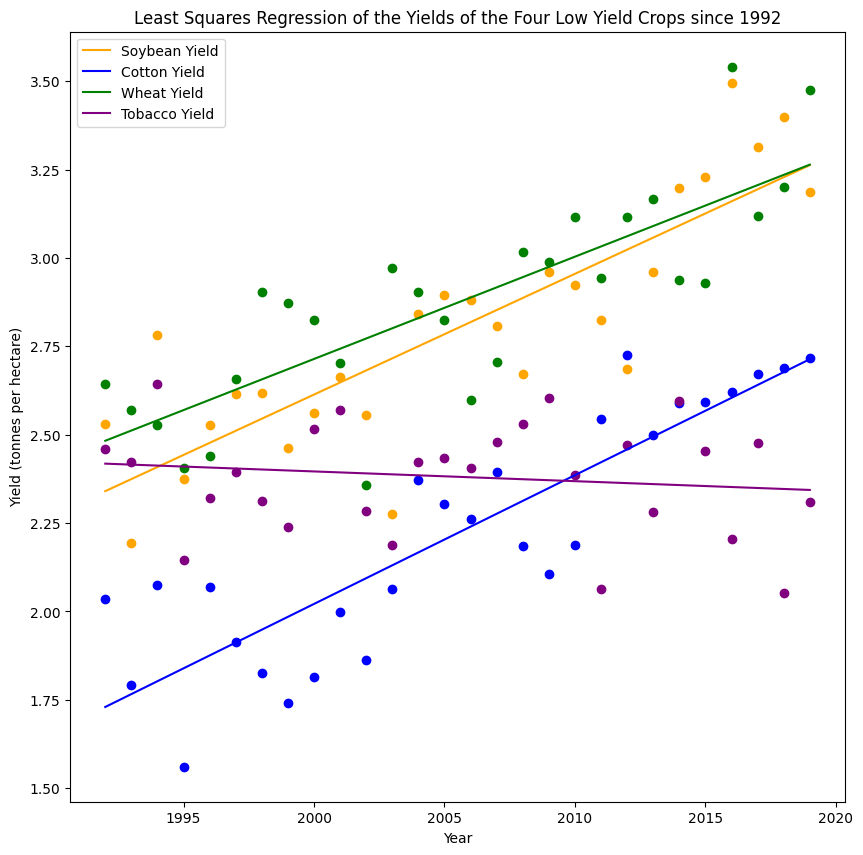

In [37]:
# Creating a plot with all of the trend lines and scatterplots

plt.rcParams["figure.figsize"] = (10,10)

# Bean line and points
x = us_yields_df['year']
y = us_yields_df['soybean_yield']
plt.scatter(x, y, color='orange')
plt.plot(x, bean(x), color='orange')

# Cotton line and points
x = us_yields_df['year']
y = us_yields_df['cotton_yield']
plt.scatter(x, y, color='blue')
plt.plot(x, cotton(x), color='blue')

# Wheat line and points
x = us_yields_df['year']
y = us_yields_df['wheat_yield']
plt.scatter(x, y, color='green')
plt.plot(x, wheat(x), color='green')

# Tobacco line and points
x = us_yields_df['year']
y = us_yields_df['tobacco_yield']
plt.scatter(x, y, color='purple')
plt.plot(x, tobacco(x), color='purple')

# Naming the axes and giving it a title
plt.xlabel("Year")
plt.ylabel("Yield (tonnes per hectare)")
plt.title("Least Squares Regression of the Yields of the Four Low Yield Crops since 1992")

# Legend
plt.legend(['_Soybean Data', 'Soybean Yield', '_Cotton Data', 'Cotton Yield','_Wheat Data', 'Wheat Yield', '_Tobacco Data', 'Tobacco Yield'])

plt.show()


Working on Trend Lines and Regression Models for the Pesticides data set

In [38]:
# Creating a seperate data frame for each pesticide that we are examining
dichlorophenoxyacetic_df = pd.DataFrame(columns= ['COMPOUND', 'YEAR','STATE_FIPS_CODE', 'COUNTY_FIPS_CODE', 'EPEST_LOW_KG', 'EPEST_HIGH_KG'])
ATRAZINE_df = pd.DataFrame(columns= ['COMPOUND', 'YEAR','STATE_FIPS_CODE', 'COUNTY_FIPS_CODE', 'EPEST_LOW_KG', 'EPEST_HIGH_KG'])
CARBARYL_df = pd.DataFrame(columns= ['COMPOUND', 'YEAR','STATE_FIPS_CODE', 'COUNTY_FIPS_CODE', 'EPEST_LOW_KG', 'EPEST_HIGH_KG'])
CHLORPYRIFOS_df = pd.DataFrame(columns= ['COMPOUND', 'YEAR','STATE_FIPS_CODE', 'COUNTY_FIPS_CODE', 'EPEST_LOW_KG', 'EPEST_HIGH_KG'])
DICAMBA_df = pd.DataFrame(columns= ['COMPOUND', 'YEAR','STATE_FIPS_CODE', 'COUNTY_FIPS_CODE', 'EPEST_LOW_KG', 'EPEST_HIGH_KG'])
GLYPHOSATE_df = pd.DataFrame(columns= ['COMPOUND', 'YEAR','STATE_FIPS_CODE', 'COUNTY_FIPS_CODE', 'EPEST_LOW_KG', 'EPEST_HIGH_KG'])
CHLOROTHALONIL_df = pd.DataFrame(columns= ['COMPOUND', 'YEAR','STATE_FIPS_CODE', 'COUNTY_FIPS_CODE', 'EPEST_LOW_KG', 'EPEST_HIGH_KG'])
PARAQUAT_df = pd.DataFrame(columns= ['COMPOUND', 'YEAR','STATE_FIPS_CODE', 'COUNTY_FIPS_CODE', 'EPEST_LOW_KG', 'EPEST_HIGH_KG'])
PENDIMETHALIN_df = pd.DataFrame(columns= ['COMPOUND', 'YEAR','STATE_FIPS_CODE', 'COUNTY_FIPS_CODE', 'EPEST_LOW_KG', 'EPEST_HIGH_KG'])

In [39]:
# Assigning data from the big dataset to the appropriate data set
for i, row in pesticides_df.iterrows():
    if row["COMPOUND"] == "2,4-D":
        dichlorophenoxyacetic_df.loc[len(dichlorophenoxyacetic_df)] = row
    elif row["COMPOUND"] == "ATRAZINE":
        ATRAZINE_df.loc[len(ATRAZINE_df)] = row
    elif row["COMPOUND"] == "CARBARYL":
        CARBARYL_df.loc[len(CARBARYL_df)] = row
    elif row["COMPOUND"] == "CHLORPYRIFOS":
        CHLORPYRIFOS_df.loc[len(CHLORPYRIFOS_df)] = row
    elif row["COMPOUND"] == "DICAMBA":
        DICAMBA_df.loc[len(DICAMBA_df)] = row
    elif row["COMPOUND"] == "GLYPHOSATE":
        GLYPHOSATE_df.loc[len(GLYPHOSATE_df)] = row
    elif row["COMPOUND"] == "CHLOROTHALONIL":
        CHLOROTHALONIL_df.loc[len(CHLOROTHALONIL_df)] = row
    elif row["COMPOUND"] == "PARAQUAT":
        PARAQUAT_df.loc[len(PARAQUAT_df)] = row
    else:
        PENDIMETHALIN_df.loc[len(PENDIMETHALIN_df)] = row

In [40]:
# Changing the variable types so that they are more friendly for analyzing
pestdflst = [dichlorophenoxyacetic_df, ATRAZINE_df, CARBARYL_df, CHLORPYRIFOS_df, DICAMBA_df, GLYPHOSATE_df,
             CHLOROTHALONIL_df, PARAQUAT_df, PENDIMETHALIN_df]
for each in pestdflst:
    each["YEAR"] = each["YEAR"].astype(str).astype(int)
    each['EPEST_LOW_KG'] = each['EPEST_LOW_KG'].astype(str).astype(float)
    each['EPEST_HIGH_KG'] = each['EPEST_HIGH_KG'].astype(str).astype(float)

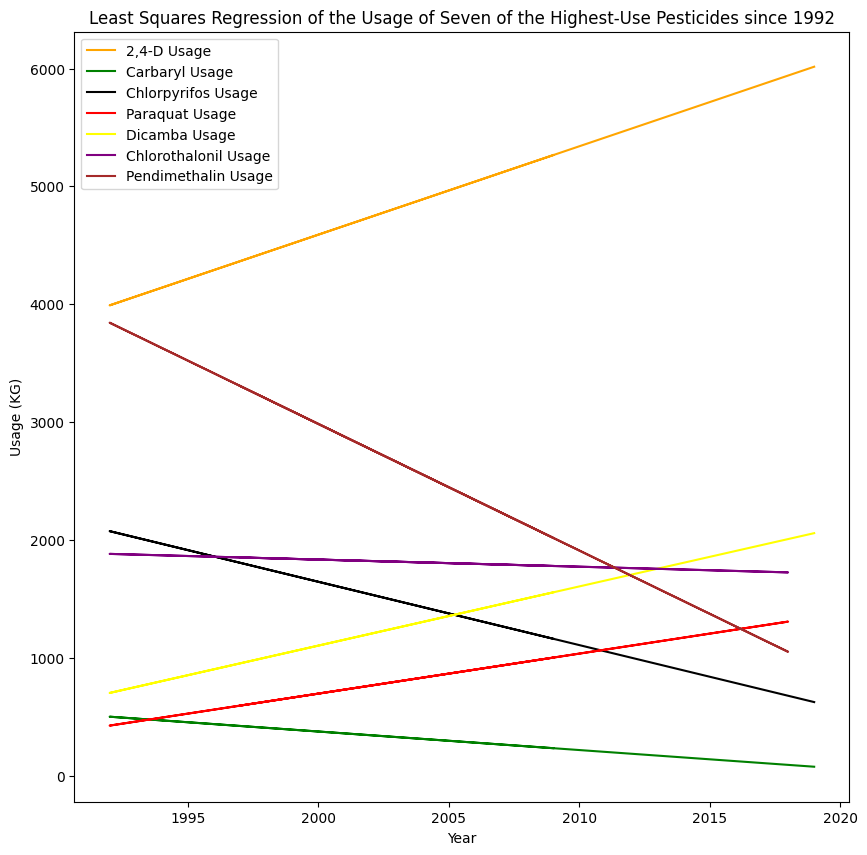

In [41]:
# Creating a plot with all of the trend lines and scatterplots

plt.rcParams["figure.figsize"] = (10,10)

# 2,4-D line and points
x = dichlorophenoxyacetic_df['YEAR']
y = dichlorophenoxyacetic_df['EPEST_LOW_KG']
z = np.polyfit(x, y, 1)  
dichlorophenoxyacetic = np.poly1d(z)
plt.plot(x, dichlorophenoxyacetic(x), color='orange')

# # Atrazine line and points
# x = ATRAZINE_df['YEAR']
# y = ATRAZINE_df['EPEST_LOW_KG']
# z = np.polyfit(x, y, 1)  
# atrazine = np.poly1d(z)
# plt.plot(x, atrazine(x), color='blue')

# Carbaryl line and points
x = CARBARYL_df['YEAR']
y = CARBARYL_df['EPEST_LOW_KG']
z = np.polyfit(x, y, 1)  
carbaryl = np.poly1d(z)
plt.plot(x, carbaryl(x), color='green')

# Chlorpyrifos line and points
x = CHLORPYRIFOS_df['YEAR']
y = CHLORPYRIFOS_df['EPEST_LOW_KG']
z = np.polyfit(x, y, 1)  
chlorpyrifos = np.poly1d(z)
plt.plot(x, chlorpyrifos(x), color='black')

# Paraquat line and points
x = PARAQUAT_df['YEAR']
y = PARAQUAT_df['EPEST_LOW_KG']
z = np.polyfit(x, y, 1)  
paraquat = np.poly1d(z)
plt.plot(x, paraquat(x), color='red')

# Dicamba line and points
x = DICAMBA_df['YEAR']
y = DICAMBA_df['EPEST_LOW_KG']
z = np.polyfit(x, y, 1)  
dicamba = np.poly1d(z)
plt.plot(x, dicamba(x), color='yellow')

# # Glyphosate line and points
# x = GLYPHOSATE_df['YEAR']
# y = GLYPHOSATE_df['EPEST_LOW_KG']
# z = np.polyfit(x, y, 1)  
# glyphosate = np.poly1d(z)
# plt.plot(x, glyphosate(x), color='pink')

# Chlorothalonil line and points
x = CHLOROTHALONIL_df['YEAR']
y = CHLOROTHALONIL_df['EPEST_LOW_KG']
z = np.polyfit(x, y, 1)  
chlorothalonil = np.poly1d(z)
plt.plot(x, chlorothalonil(x), color='purple')

# Pendimethalin line and points
x = PENDIMETHALIN_df['YEAR']
y = PENDIMETHALIN_df['EPEST_LOW_KG']
z = np.polyfit(x, y, 1)  
pendimethalin = np.poly1d(z)
plt.plot(x, pendimethalin(x), color='brown')

# Naming the axis and giving a title
plt.xlabel("Year")
plt.ylabel("Usage (KG)")
plt.title("Least Squares Regression of the Usage of Seven of the Highest-Use Pesticides since 1992")

# Adding a legend 
plt.legend(['2,4-D Usage', 'Carbaryl Usage', 'Chlorpyrifos Usage',
            'Paraquat Usage', 'Dicamba Usage', 'Chlorothalonil Usage',
              'Pendimethalin Usage'])

plt.show()

Map

In [42]:
# Load the shapefile
us_counties = gpd.read_file('UScounties/UScounties.shp')

In [43]:
# Make the FIPS codes strings so that we can add leading zeroes to match the format of the FIPS codes from the shapefile
GLYPHOSATE_df["STATE_FIPS_CODE"] = GLYPHOSATE_df["STATE_FIPS_CODE"].astype(str)
GLYPHOSATE_df["COUNTY_FIPS_CODE"] = GLYPHOSATE_df["COUNTY_FIPS_CODE"].astype(str)

In [44]:
# Add the leading zeroes to the FIPS codes
GLYPHOSATE_df["STATE_FIPS_CODE"] = GLYPHOSATE_df["STATE_FIPS_CODE"].str.zfill(2)
GLYPHOSATE_df["COUNTY_FIPS_CODE"] = GLYPHOSATE_df["COUNTY_FIPS_CODE"].str.zfill(3)

In [45]:
# Combine the state and county codes (this is the format of the shapefile and we need to merge on the FIPS code to make the map)
GLYPHOSATE_df['county_fips'] = GLYPHOSATE_df['STATE_FIPS_CODE'] + GLYPHOSATE_df['COUNTY_FIPS_CODE']

In [46]:
# Create a data frame based on the just the FIPS codes and pesticide estimates since that is all the info we need
mapdata = pd.DataFrame({
    'county_fips' : GLYPHOSATE_df['county_fips'],  
    'pestagekgs' : GLYPHOSATE_df['EPEST_LOW_KG']
})

In [47]:
# Rename the FIPS file so that it matches and merge data with shapefile on county FIPS
us_counties['county_fips'] = us_counties['FIPS'] 
merged_map = us_counties.merge(mapdata, on='county_fips', how='left')

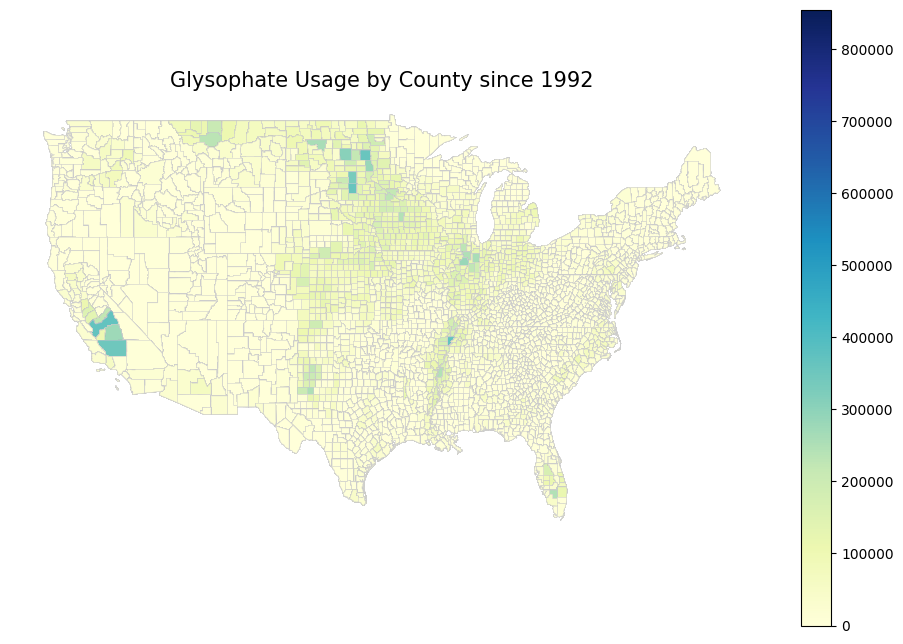

In [48]:
# Plot map with different shades based on the amount of pesticide in a county
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_map.plot(
    column='pestagekgs',  
    cmap='YlGnBu',              
    linewidth=0.3,   
    ax=ax,
    edgecolor='0.8',       
    legend=True         
)

ax.set_title('Glysophate Usage by County since 1992', fontdict={'fontsize': 15})
ax.axis('off')
plt.show()


Linear Regression!

In [207]:
pesticides_df['year'] = pesticides_df['YEAR']

In [208]:
# Aggregate pesticides usage data by year and crop
pesticides_grouped = pesticides_df.groupby(['year', 'COMPOUND'])['EPEST_LOW_KG'].sum().reset_index()

In [209]:
# Merge with yield data
merged_df = pd.merge(us_yields_df, pesticides_grouped, on=['year'], how='inner')

In [210]:
# Create and average variable so that we can determine the amount of tonnage overall in the US
merged_df['total_yield'] = (merged_df['maize_yield'] + merged_df['cotton_yield'] + merged_df['soybean_yield'] + merged_df['fruit_yield'] + merged_df['potato_yield'] + merged_df['tobacco_yield'] + merged_df['vegetables_yield'] + merged_df['wheat_yield']) / 8

In [211]:
# Eliminate the columns that we do not want and group the columns that we do want together (sum all of the EPEST estimates because we are looking at overall pesticide application)
merged_df = merged_df[['year', 'COMPOUND', 'EPEST_LOW_KG', 'total_yield']]
merged_df = merged_df.groupby(['year', 'total_yield'])['EPEST_LOW_KG'].sum().reset_index()

In [212]:
# Add other AVERAGED explanatory variables to see what kind of effect they have on r-squared and what correlation they have with crop yield
# and with one another
merged_df['temperature'] = [53.6, 50.3, 54.7, 53.9, 54.3, 53.4, 52.9, 53.3, 53.7, 53.8, 52.0, 55.0, 52.1, 53.4, 53.8, 53.8,
                            51.9, 52.1, 52.7, 51.8, 56.6, 53.3, 55.6, 56.3, 56.2, 56.1, 56.2, 53.6]
merged_df['rainfall'] = [31.3, 32.6, 30.6, 32.7, 33.7, 31.9, 33.9, 28.5, 28.2, 29.0, 29.1, 30.5, 33.3, 30.1, 29.8, 29.2, 31.2,
                         32.3, 31.4, 30.1, 27.5, 31.1, 30.9, 34.6, 31.4, 32.3, 34.7, 34.8]

In [213]:
corr = merged_df.corr()
corr

,year,total_yield,EPEST_LOW_KG,temperature,rainfall
year,1.000000,0.973599,0.982265,0.441383,0.178000
total_yield,0.973599,1.000000,0.955342,0.399938,0.162787
EPEST_LOW_KG,0.982265,0.955342,1.000000,0.486528,0.146747
temperature,0.441383,0.399938,0.486528,1.000000,0.036160
rainfall,0.178000,0.162787,0.146747,0.036160,1.000000


<Axes: >

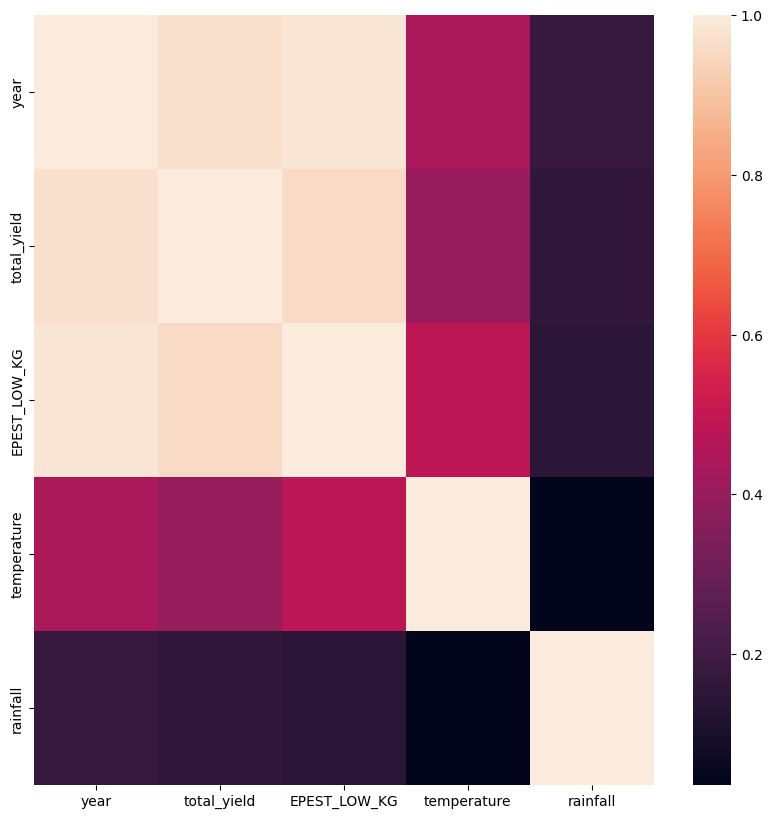

In [214]:
sns.heatmap(corr)

In [215]:
# Define X and y for the linear regression
X = merged_df[['EPEST_LOW_KG', 'temperature', 'rainfall']]
y = merged_df['total_yield']

In [216]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [217]:
# Linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [218]:
# Evaluate performance
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score: 0.861044586591075
MSE: 0.17931411020846313
RMSE: 0.42345496833602403


In [219]:
# Array of years to predict values for
future_years = np.array([2020, 2021, 2022, 2023, 2024]).reshape(-1, 1)

In [220]:
# Find the average increase from the pesticide estimates (year over year)
average_increase = merged_df['EPEST_LOW_KG'].diff().mean()
future_tonnage = pd.DataFrame(columns= ['EPEST_LOW_KG', 'temperature','rainfall'])
future_tonnage['EPEST_LOW_KG'] = merged_df['EPEST_LOW_KG'].iloc[-1] + average_increase * np.arange(1, 6)
future_tonnage['temperature'] = merged_df['temperature']
future_tonnage['rainfall'] = merged_df['rainfall']

In [221]:
# Feed the model the extrapolated pesticide estimates
future_yields = model.predict(future_tonnage)

In [222]:
# Create a dataframe for visualization
future_df = pd.DataFrame({'year': future_years.flatten(), 'predicted_yield': future_yields})
future_df

,year,predicted_yield
0,2020,16.008512
1,2021,16.199462
2,2022,16.202097
3,2023,16.327249
4,2024,16.424511


In [223]:
# Create a data frame that uses the ORIGINAL yield data to summarize all of the data we need post-2019 so that we can compare
help_df = crop_yield_df[crop_yield_df['country'] == 'United States']
help_df = help_df[help_df['year'] >= 2019]
help_df['total_yield'] = (help_df['maize_yield'] + help_df['cotton_yield'] + help_df['soybean_yield'] + help_df['fruit_yield'] + help_df['potato_yield'] + help_df['tobacco_yield'] + help_df['vegetables_yield'] + help_df['wheat_yield']) / 8
help_df = help_df[['total_yield', 'year']]

In [224]:
# Merge the dataset together so that we have a prediction and an actual yield
future_df = pd.merge(future_df, help_df, on = ['year'], how = 'inner')
future_df

,year,predicted_yield,total_yield
0,2020,16.008512,16.397974
1,2021,16.199462,15.946505
2,2022,16.202097,15.828090
3,2023,16.327249,NaN


In [225]:
# Eliminate the columns that we don't need
future_df = future_df[['year', 'predicted_yield']]
merged_df = merged_df[['year', 'total_yield']]

In [226]:
# Trend line for the regression
x = merged_df['year']
y = merged_df['total_yield']
z = np.polyfit(x, y, 1)  
past = np.poly1d(z)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


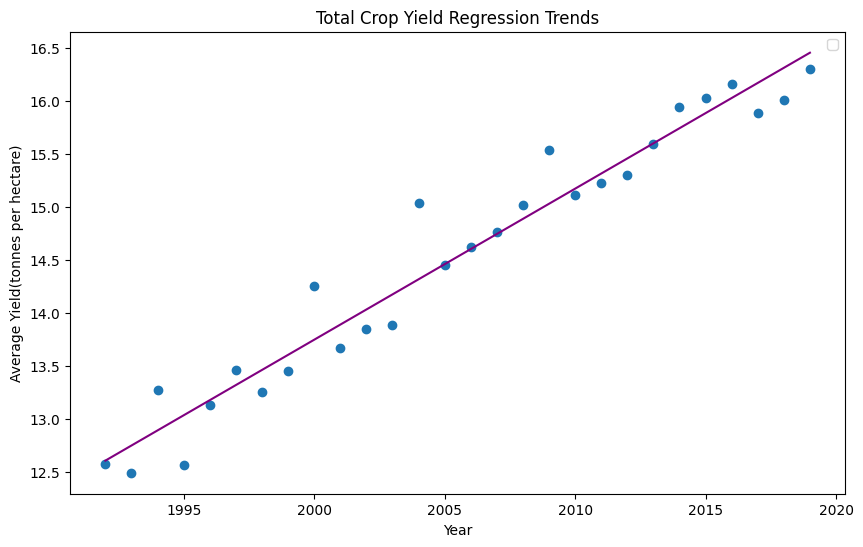

In [227]:
# Plot the regression line against all of the data
plt.figure(figsize = (10, 6))
plt.scatter(merged_df['year'], merged_df['total_yield'])
plt.plot(x, past(x), color='purple')
plt.title('Total Crop Yield Regression Trends')
plt.xlabel('Year')
plt.ylabel('Average Yield(tonnes per hectare)')
plt.legend()
plt.show()